### Import Libraries

In [416]:
"If it does not work use code below while running this notebook in this dir."
import sys
import os
# sys.path.append(os.path.abspath(os.getcwd()))
sys.path.append(os.path.abspath(os.getcwd() + "\\Desktop\\CIHW"))

%load_ext autoreload


%autoreload 2
from mytorch import Tensor, Model
%autoreload 2
from mytorch import activation as active_func
%autoreload 2
from mytorch import loss as loss_func
%autoreload 2
from mytorch import optimizer as optim 
from mytorch import layer as nn
from mytorch.util import DataLoader
import numpy as np

from mytorch.util import flatten
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [417]:
print(sys.path[-1])

C:\Users\armin\Desktop\CIHW


### Load MNIST

In [418]:
"""
load data set with given data loader.
you have 10000 train data, 1000 for each number, remember to shuffle training data.
you have 1000 test data, 100 for each number.

loaded data is a list of (img, label)
type of img is Tensor.

TODO: you have to get this list and create batches for training.
you can also apply this changes later in the Training part for convenience.
"""
data_loader = DataLoader(train_addr='C:/Users/armin/Desktop/CIHW/MNIST/train', test_addr='C:/Users/armin/Desktop/CIHW/MNIST/test')
data_loader.load()
"you can see how data is loaded"
# print(data_loader.getTrain()[0][0].shape)
# print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...


'you can see how data is loaded'

In [419]:
print(data_loader.getTrain()[0][0].shape)
print(data_loader.getTrain()[0][1].shape)

print(data_loader.getTrain()[0][0].shape)
print(len(data_loader.getTrain()[1][0].shape))

# for images, _ in data_loader.getTrain():
#     images.data = images.data / 255.0
# print(data_loader.getTrain()[0][0].data)
#print(data_loader.getTrain()[0][1].data[0:5])
# print(data_loader.getTrain())

(500, 28, 28)
(500,)
(500, 28, 28)
3


In [420]:
def reshape(x:Tensor, shape) -> Tensor:
    data = x.data.reshape(-1, shape[0]*shape[1])
    req_grad = x.requires_grad
    depends_on = x.depends_on
    return Tensor(data=data, requires_grad=req_grad, depends_on=depends_on)

def reshape_labels(labels: Tensor) -> Tensor:
    newData = np.zeros((labels.shape[0], 10))
    for i, initial_value in enumerate(labels.data):
        newData[i, initial_value] = 1
    return Tensor(newData, labels.requires_grad, labels.depends_on)


### Define and Create your Model

In [421]:
class MyModel(Model):
    def __init__(self):
        "TODO: define your layers. order is important" 
        input_size = 28*28
        output_size = 10
        hidden_layer_1 = 128 
        hidden_layer_2 = 128 
        self.fc1 = nn.Linear(input_size, hidden_layer_1, need_bias=True)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2, need_bias=True)
        self.fc3 = nn.Linear(hidden_layer_2, output_size, need_bias=True)
        self.layers = [self.fc1, self.fc3]

    def forward(self, x: Tensor) -> Tensor:
        "TODO: define forward pass"
        x = reshape(x, (28, 28))
        x = active_func.leaky_relu(self.fc1(x))
        x = active_func.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return active_func.softmax(x)

model = MyModel()
print(model.summary())

fc1:  linear - total param: 100352 - in: 784, out: 128
fc2:  linear - total param: 16384 - in: 128, out: 128
fc3:  linear - total param: 1280 - in: 128, out: 10
None


### Choose a Loss Function

In [422]:
"TODO: choose a proper loss function"
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [423]:
"TODO: choose a proper optimizer"
optimizer = optim.SGD(model.layers, learning_rate=0.06)

### Training Model

In [424]:
import numpy as np

In [425]:
"TODO: define number of epoch and train batches of data on your model. also test each epoch."
EPOCH = 64
def normalize_images(images: Tensor) -> Tensor:
    images.data = images.data / 255.0

train_epoch_size = data_loader.getTrain()[0][0].shape[0] * len(data_loader.getTrain())
train_batch_size =  data_loader.getTrain()[0][0].shape[0]
test_epoch_size = data_loader.getTest()[0][0].shape[0] * len(data_loader.getTest())
test_batch_size =  data_loader.getTest()[0][0].shape[0]
train_acc = []
test_acc = []
for i in range(EPOCH):
    epoch_train_acc = 0.0
    epoch_valid_acc = 0.0
    train_loss = 0.0
    valid_loss = 0.0
    "TODO: train over your defined batches and save train accuracy for each epoch."
    for images, labels in data_loader.getTrain():
        if i == 0:
            normalize_images(images)
        predicted = model.forward(images)
        reshaped_labels = reshape_labels(labels)
        epoch_train_acc += np.sum(np.argmax(predicted.data, axis=1) == labels.data)/train_epoch_size
        loss = criterion(predicted, reshaped_labels)
        loss = loss * Tensor(np.ones((1)) / train_batch_size)
        loss.backward(Tensor(np.ones_like(loss.data)))
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.data[0] 
    "TODO: test your model after each training and save test accuracy for each epoch."
    for images, labels in data_loader.getTest():
        if i == 0:
            normalize_images(images)
        reshaped_labels = reshape_labels(labels)
        output = model.forward(images)
        epoch_valid_acc += np.sum(np.argmax(output.data, axis=1) == labels.data)/test_epoch_size
        loss = criterion(output, reshaped_labels)
        loss = loss * Tensor(np.ones((1)) / test_batch_size)
        valid_loss += loss.data[0]
     
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/train_epoch_size
    valid_loss = valid_loss/test_epoch_size
    test_acc.append(epoch_valid_acc)
    train_acc.append(epoch_train_acc)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i+1, 
        train_loss,
        valid_loss
        ))
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        i+1, 
        epoch_train_acc,
        epoch_valid_acc
        ))

Epoch: 1 	Training Loss: 0.001981 	Validation Loss: 0.009580
Epoch: 1 	Training Accuracy: 0.168200 	Validation Accuracy: 0.247000
Epoch: 2 	Training Loss: 0.001817 	Validation Loss: 0.008850
Epoch: 2 	Training Accuracy: 0.391400 	Validation Accuracy: 0.435000
Epoch: 3 	Training Loss: 0.001639 	Validation Loss: 0.008001
Epoch: 3 	Training Accuracy: 0.561400 	Validation Accuracy: 0.577000
Epoch: 4 	Training Loss: 0.001443 	Validation Loss: 0.007085
Epoch: 4 	Training Accuracy: 0.676700 	Validation Accuracy: 0.670000
Epoch: 5 	Training Loss: 0.001250 	Validation Loss: 0.006215
Epoch: 5 	Training Accuracy: 0.735700 	Validation Accuracy: 0.713000
Epoch: 6 	Training Loss: 0.001081 	Validation Loss: 0.005473
Epoch: 6 	Training Accuracy: 0.768900 	Validation Accuracy: 0.729000
Epoch: 7 	Training Loss: 0.000944 	Validation Loss: 0.004873
Epoch: 7 	Training Accuracy: 0.792600 	Validation Accuracy: 0.753000
Epoch: 8 	Training Loss: 0.000838 	Validation Loss: 0.004402
Epoch: 8 	Training Accuracy: 

### Evaluate Model Performance

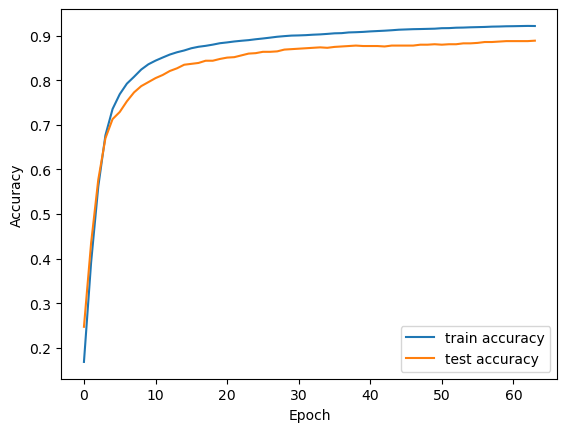


On train - best accuracy: 0.92, final accuracy: 0.92
On test - best accuracy: 0.89, final accuracy: 0.89


In [426]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();
best_train_acc = np.max(train_acc)
best_test_acc = np.max(test_acc)

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))